In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer
import ast

# Load the dataset
file_path = '../tagged_data/DD_tables_tagged.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
data.head()


,table_id,table_width,table_height,table_left,table_top,table_page,cell_count,row_count,column_count,content,...,table_title_count,table_footer_count,table_type,layout_title_text,table_type_SEMI_STRUCTURED_TABLE,table_type_STRUCTURED_TABLE,entities_int_padded,cluster_weighted,table_class,filename
0,f7e373c8-dfb2-4dc8-b06c-2262b9c0214b,0.858734,0.211050,0.079946,0.617510,105,63,12,6,"[[['Comments:', 'The', 'door', 'interlock', 'i...",...,0,1,STRUCTURED_TABLE,AIR SWITCH INSPECTION & TEST REPORT,0,1,"[[1, 1, 1, 1, 1, 0], [5, 5, 5, 5, 5, 0], [5, 5...",10,BIGRID_STACKED,101-300.pdf
1,40e23240-c02e-48da-aa24-a9401e55e946,0.846772,0.059921,0.083297,0.196138,91,19,4,6,"[[['Contact', 'Resistance', 'Tests'], ['Commen...",...,1,1,STRUCTURED_TABLE,INSULATED CASE CIRCUIT BREAKER INSPECTION AND ...,0,1,"[[4, 4, 1, 1, 1, 0], [5, 5, 5, 5, 5, 0], [5, 5...",5,BIGRID,1-100.pdf
2,cc9ea227-37f5-424f-a743-50a37b0aa22d,0.846762,0.059921,0.083304,0.196121,89,19,4,6,"[[['Contact', 'Resistance', 'Tests'], ['Commen...",...,1,1,STRUCTURED_TABLE,INSULATED CASE CIRCUIT BREAKER INSPECTION AND ...,0,1,"[[4, 4, 1, 1, 1, 0], [5, 5, 5, 5, 5, 0], [5, 5...",5,BIGRID,1-100.pdf
3,26abc4ba-e65a-4db6-89d8-300968eb7028,0.846388,0.059451,0.086198,0.456601,249,18,4,6,"[[['Contact', 'Resistance', 'Tests']], [['Cont...",...,1,0,STRUCTURED_TABLE,Low VOLTAGE AIR CIRCUIT BREAKER TEST REPORT (C...,0,1,"[[4, 4, 1, 1, 1, 0], [5, 5, 5, 5, 5, 0], [5, 5...",5,BIGRID,750-999.pdf
4,b77b01cb-2e25-4afd-b9ad-06785ee1758e,0.854339,0.060009,0.079361,0.313965,34,18,4,6,"[[['Contact', 'Resistance', 'Tests']], [['Cont...",...,1,0,STRUCTURED_TABLE,MOLDED CASE STATIC TRIP CIRCUIT BREAKER TEST R...,0,1,"[[4, 4, 1, 1, 1, 0], [5, 5, 5, 5, 5, 0], [5, 5...",5,BIGRID,750-999.pdf


In [2]:
## ONE-HOT ENCODING FOR TABLE_TYPE

# Initialize the OneHotEncoder
one_hot_encoder = OneHotEncoder()

# Fit and transform 'table_type' column
table_type_encoded = one_hot_encoder.fit_transform(data[['table_type']])

# Convert the sparse matrix to a dense array (if needed)
table_type_encoded_dense = table_type_encoded.toarray()

# Generate column names for the one-hot encoded variables
column_names = one_hot_encoder.get_feature_names_out(['table_type'])

# Convert the array to a DataFrame with column names
table_type_encoded_df = pd.DataFrame(table_type_encoded_dense, columns=column_names)

# Concatenate the original DataFrame with the new one-hot encoded DataFrame
data = pd.concat([data.reset_index(drop=True), table_type_encoded_df.reset_index(drop=True)], axis=1)

print('Completed one-hot encoding for table_type')

Completed one-hot encoding for table_type


In [3]:
# Function to pad all lists to the same length

def pad_all_lists(list_of_list_of_lists, pad_value=0):
    # Determine the longest inner list length
    max_inner_length = max(len(inner) for outer in list_of_list_of_lists for inner in outer)
    
    # Determine the max number of inner lists within any outer list
    max_outer_length = max(len(outer) for outer in list_of_list_of_lists)
    
    # Pad inner lists
    padded_inner = [[inner + [pad_value] * (max_inner_length - len(inner)) for inner in outer] for outer in list_of_list_of_lists]
    
    # Pad outer lists to ensure they all have the same number of inner lists, with each inner list padded to the same length
    padded_outer = [outer + [[pad_value] * max_inner_length] * (max_outer_length - len(outer)) for outer in padded_inner]
    
    return padded_outer

In [4]:
## LABEL ENCODING FOR ENTITIES

# Convert entities from string to nested list
data['entities'] = data['entities'].apply(ast.literal_eval)

# Extract all unique entity types
unique_entity_types = set(entity for sublist in data['entities'] for item in sublist for entity in item)

# Map unique entity types to integers starting from 1
entity_type_to_int = {entity: i + 1 for i, entity in enumerate(sorted(unique_entity_types))}

# Transform the entities lists using the mapping
data['entities_int'] = data['entities'].apply(lambda x: [[entity_type_to_int[entity] for entity in sublist] for sublist in x])

print("Unique entity types:", unique_entity_types)
print("Entity type to integer mapping:", entity_type_to_int)

print('\nCompleted label encoding and padding for entities')

# Apply padding to the 'entities_int' column
data['entities_int_padded'] = pad_all_lists(data['entities_int'].tolist())
data.drop('entities_int', axis=1, inplace=True) 

print(f'\nMax table rows observed in dataset: {data["row_count"].max()}')
print(f'Max table columns observed in dataset: {data["column_count"].max()}')
print(f'\nPadded all entities lists to contain {len(data["entities_int_padded"][0])} rows and {len(data["entities_int_padded"][0][0])} columns')

## Flatten the entities_int_padded column
flattened_entities = np.array([np.array(row).flatten() for row in data['entities_int_padded']])
print(flattened_entities.shape)


Unique entity types: {'normal', 'TABLE_SECTION_TITLE', 'TABLE_TITLE', 'COLUMN_HEADER', 'TABLE_FOOTER'}
Entity type to integer mapping: {'COLUMN_HEADER': 1, 'TABLE_FOOTER': 2, 'TABLE_SECTION_TITLE': 3, 'TABLE_TITLE': 4, 'normal': 5}

Completed label encoding and padding for entities

Max table rows observed in dataset: 17
Max table columns observed in dataset: 7

Padded all entities lists to contain 16 rows and 6 columns
(2703, 96)


In [5]:
## TF-IDF VECTORIZATION FOR MEANINGFUL STRINGS

# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')

# Fit and transform the text fields to TF-IDF weighted matrices
tfidf_content = tfidf_vectorizer.fit_transform(data['content'])
tfidf_layout_title_text = tfidf_vectorizer.fit_transform(data['layout_title_text'])

# Convert the TF-IDF matricies to dense arrays
tfidf_content = tfidf_content.toarray()
tfidf_layout_title_text = tfidf_layout_title_text.toarray()

# Check the shape of the resulting TF-IDF matrix
print(tfidf_content.shape, tfidf_layout_title_text.shape)

(2703, 1000) (2703, 16)


In [6]:
# Create a list of feature column names: numerical features + one-hot encoded features
feature_columns = ['table_width', 'table_height', 'table_left', 'table_top', 'cell_count', 'row_count', 'column_count', 'child_count', 'merged_cell_count', 'table_title_count', 'table_footer_count'] + [col for col in data.columns if col.startswith('table_type_')]
numerical_and_onehot_features = data[feature_columns]

# Perform PCA on the numerical features to reduce them to a comparable scale as the TF-IDF features
pca = PCA(n_components=2)
numerical_features_reduced = pca.fit_transform(numerical_and_onehot_features)

# Display the first few rows of the numerical and one-hot encoded features
numerical_and_onehot_features.head()

,table_width,table_height,table_left,table_top,cell_count,row_count,column_count,child_count,merged_cell_count,table_title_count,table_footer_count,table_type_SEMI_STRUCTURED_TABLE,table_type_SEMI_STRUCTURED_TABLE,table_type_STRUCTURED_TABLE,table_type_STRUCTURED_TABLE,table_type_SEMI_STRUCTURED_TABLE,table_type_SEMI_STRUCTURED_TABLE,table_type_STRUCTURED_TABLE,table_type_STRUCTURED_TABLE
0,0.858734,0.211050,0.079946,0.617510,63,12,6,55,7,0,1,0,0.0,1,1.0,0,0.0,1,1.0
1,0.846772,0.059921,0.083297,0.196138,19,4,6,15,2,1,1,0,0.0,1,1.0,0,0.0,1,1.0
2,0.846762,0.059921,0.083304,0.196121,19,4,6,15,2,1,1,0,0.0,1,1.0,0,0.0,1,1.0
3,0.846388,0.059451,0.086198,0.456601,18,4,6,15,2,1,0,0,0.0,1,1.0,0,0.0,1,1.0
4,0.854339,0.060009,0.079361,0.313965,18,4,6,15,2,1,0,0,0.0,1,1.0,0,0.0,1,1.0


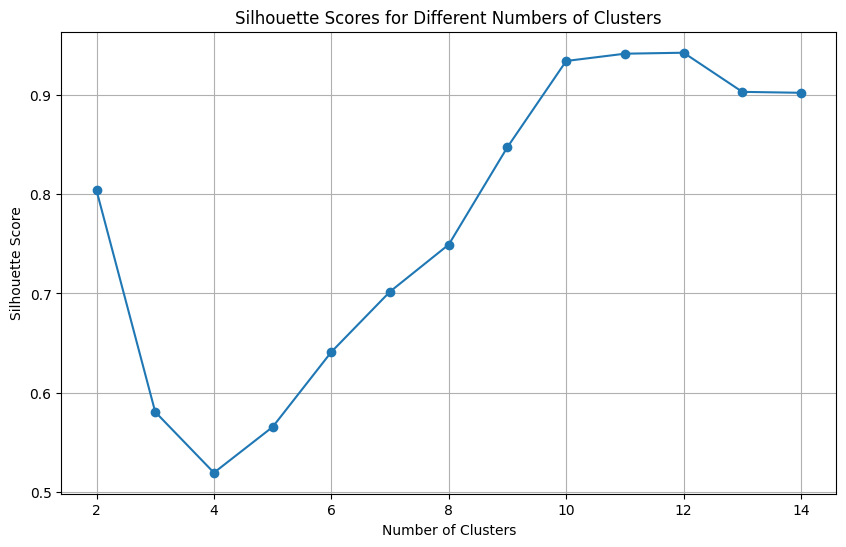

(12, 0.9420200595392945)

In [7]:
# Apply a manual weight to the TF-IDF features
tfidf_content_weighted = tfidf_content * 0.20  # Edit here to apply a higher weight

# Combine the PCA-reduced numerical features with the TF-IDF features
combined_features = np.hstack((numerical_features_reduced, tfidf_content_weighted, tfidf_layout_title_text, flattened_entities))

# Range of cluster numbers to evaluate
cluster_range = range(2, 15)

# Initialize list to store silhouette scores
silhouette_scores = []

# Calculate silhouette scores for different numbers of clusters
for n_clusters in cluster_range:
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(combined_features)
    silhouette_avg = silhouette_score(combined_features, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# Find the number of clusters with the highest silhouette score
optimal_clusters = cluster_range[np.argmax(silhouette_scores)]
optimal_clusters, max(silhouette_scores)


In [8]:
# Apply a manual weight to the TF-IDF features
tfidf_content_weighted = tfidf_content * 0.20  # Edit here to apply a higher weight

# Combine the weighted TF-IDF features with the PCA-reduced numerical features
combined_features_weighted = np.hstack((numerical_features_reduced, tfidf_content_weighted, tfidf_layout_title_text, flattened_entities))

# Apply K-means clustering with N clusters to the weighted combined features
n_clusters_weighted = 13
kmeans_weighted = KMeans(n_clusters=n_clusters_weighted, random_state=42)
cluster_labels_weighted = kmeans_weighted.fit_predict(combined_features_weighted)

# Add the new weighted cluster labels to the original dataset
data['cluster_weighted'] = cluster_labels_weighted

# Define the path for the newly tagged version of the dataset with weighted clusters
tagged_file_path_weighted = '../DD_preprocessed_tables2.csv'

# Save the dataset with the new weighted cluster tags to a CSV file
data.to_csv(tagged_file_path_weighted, index=False)
